In [13]:
# https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/

from dotenv import load_dotenv

from langchain_ollama import ChatOllama
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
# from langgraph.types import Command, interrupt

load_dotenv()

True

In [7]:
import random
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

In [19]:
# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
# llm = ChatOllama(model="mistral-small:latest", temperature=0, base_url = "http://192.168.1.203:11434")
llm = ChatOllama(model="qwq:latest", temperature=0, base_url = "http://192.168.1.203:11434")

In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [21]:
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [22]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})

{'messages': [HumanMessage(content='who is the winnner of the us open', additional_kwargs={}, response_metadata={}, id='b6476a0f-d5b0-472c-b8d4-0b136257df9b'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwq:latest', 'created_at': '2025-04-30T05:57:21.205568359Z', 'done': True, 'done_reason': 'stop', 'total_duration': 41102748889, 'load_duration': 22307323915, 'prompt_eval_count': 187, 'prompt_eval_duration': 2064000000, 'eval_count': 394, 'eval_duration': 15409000000, 'model_name': 'qwq:latest'}, id='run-7beaed94-a013-4772-be59-61b2113cd79b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US Open winner 2023'}, 'id': '80075012-9a88-4194-8595-b4e2632db907', 'type': 'tool_call'}], usage_metadata={'input_tokens': 187, 'output_tokens': 394, 'total_tokens': 581}),
  ToolMessage(content='[{"url": "https://en.wikipedia.org/wiki/2023_US_Open_(tennis)", "content": "Find sources:\xa0\\"2023 US Open\\"\xa0tennis\xa0–\xa0news\xa0· newspapers

In [23]:
import operator

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [24]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [25]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)

In [26]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current year to determine the most recent Australia Open winner.', 'Research the most recent Australia Open winner for the identified year.', 'Once the winner is identified, look up their personal information to find their hometown.'])

In [27]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | llm.with_structured_output(Act)

In [28]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [29]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

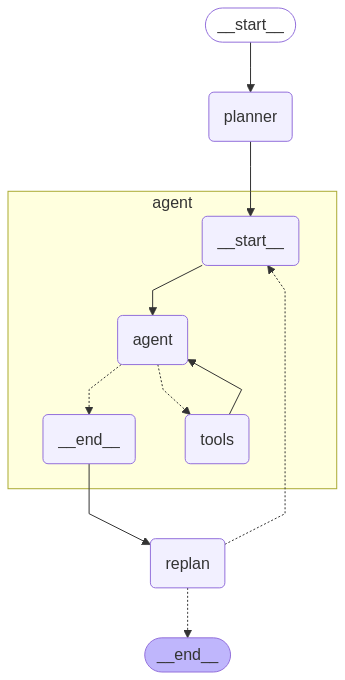

In [30]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [31]:
config = {"recursion_limit": 500}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Check the official website of the 2024 Australian Open to find the list of winners.', "Identify the men's singles winner from the list.", "Once the winner's name is known, search for their biography or profile.", 'Look for the hometown or place of birth in their biography.', 'Verify the information from another credible sports news source to ensure accuracy.']}
{'past_steps': [('Check the official website of the 2024 Australian Open to find the list of winners.', '<think>\nOkay, let me tackle this step by step. The user wants me to execute step 1 of their plan, which is to check the official website of the 2024 Australian Open for the list of winners. Since I can\'t access the internet directly, I used the Tavily search function with the query "2024 Australian Open official website tournament winners list". The tool provided some search results, including Wikipedia pages and the official Australian Open site\'s honor roll.\n\nLooking at the first result from Wikipedia, under